(binary_hgf)=
# The binary Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/1.1-Binary_HGF.ipynb)

In [1]:
%%capture
import sys

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import first_level_binary_surprise

if 'google.colab' in sys.modules:
    !pip install pyhgf

In this notebook, we demonstrate how to create and fit the standard two-level and three-level Hierarchical Gaussian Filters (HGF) for binary inputs. This class share a lot of similarities with its continuous counterpart described in the [next tutorial](continuous_hgf). Here, the difference is that the input node accepts binary data. Binary responses are widely used in decision-making neuroscience, and standard reinforcement learning algorithms like Rescorla-Wagner are tailored to learn outcomes probability under such configuration. Here, by using a Hierarchical Gaussian Filter, we want to be able to learn from the evolution of higher-level volatility, and the parameters that are influencing the strength of the coupling between lower-level nodes with their parents (i.e. $\omega$, or the `evolution rate` of the 1rst and 2nd levels nodes). The binary version of the Hierarchical Gaussian Filter can take the following structures:

```{figure} ../images/binary.png
---
name: binary-hgf
---
The two-level and three-level Hierarchical Gaussian Filter for binary inputs. Note that the first level $X_{1}$ is a value parent for the binary input node $\mathcal{B}$, and has itself a value parent $X_{2}$. A volatility parent is only used in the context of a 3-level HGF. This is a specificity of the binary model.
```

In this example, we will use data from a decision-making task where the outcome probability was manipulated across time, and observe how the binary HGFs can track switches in response probabilities.

## Imports
We import a time series of binary observations from the decision task described in {cite:p}`Iglesias2021`.

In [2]:
u, _ = load_data("binary")

## Fitting the binary HGF with fixed parameters
### The two-level binary Hierarchical Gaussian Filter
#### Create the model

The node structure corresponding to the two-level and three-level Hierarchical Gaussian Filters are automatically generated from `model_type` and `n_levels` using the nodes parameters provided in the dictionaries. Here we are not performing any optimization so those parameters are fixed to reasonable values.

```{note}
The response function used is the binary surprise at each time point ({py:func}`pyhgf.response.first_level_binary_surprise`). In other words, at each time point the model try to update its hierarchy to minimize the discrepancy between the expected and real next binary observation. See also [this tutorial](custom_response_functions) to see how to create a custom response function.
```

In [3]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": .0, "2": .5},
    initial_precision={"1": .0, "2": 1.0},
    tonic_volatility={"2": -3.0},
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Creating a binary Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.


I0000 00:00:1700143865.696682   14306 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


... Cache the belief propagation function.


This function creates an instance of an HGF model automatically parametrized for a two-level binary structure, so we do not have to worry about creating the node structure ourselves. This class also embed function to add new observations and plot results that we are going to use below. We can have a look at the node structure itself using the {py:func}`pyhgf.plots.plot_network` function. This function will automatically dray the provided node structure using [Graphviz](https://github.com/xflr6/graphviz).

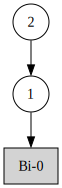

In [4]:
two_levels_hgf.plot_network()

#### Add data

In [5]:
# Provide new observations
two_levels_hgf = two_levels_hgf.input_data(input_data=u)

Adding 320 new observations.


#### Plot trajectories

A Hierarchical Gaussian Filter is acting as a Bayesian filter when presented with new observation, and by running the update equation forward, we can observe the trajectories of the parameters of the node that are being updated after each new observation (i.e. the mean $\mu$ and the precision $\pi$). The `plot_trajectories` function automatically extracts the relevant parameters given the model structure and will plot their evolution together with the input data.

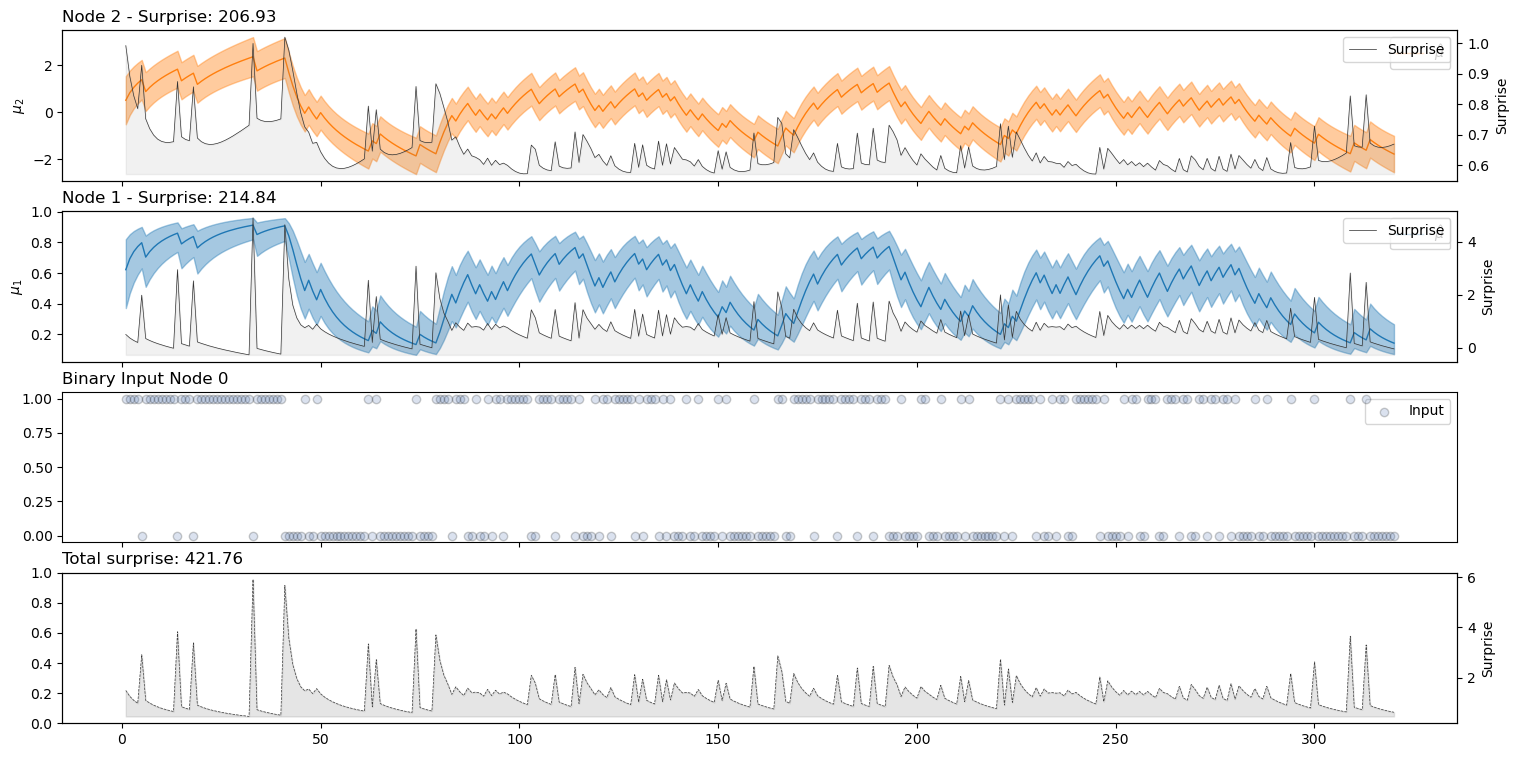

In [6]:
two_levels_hgf.plot_trajectories();

#### Surprise
We can see that the surprise will increase when the time series exhibit more unexpected behaviours. The degree to which a given observation is expected will depend on the expected value and volatility in the input node, which is influenced by the values of higher-order nodes. One way to assess model fit is to look at the total binary surprise for each observation. These values can be returned from the fitted model using the `surprise` method:

In [7]:
two_levels_hgf.surprise()

Array(202.97632, dtype=float32)

```{note}
The surprise of a model under the observation of new data directly depends on the response function that was used. New response functions can be added and provided using different `response_function_parameters` and `response_function` in the {py:func}`pyhgf.model.HGF.surprise` method. The surprise is then defined as the negative log probability of new observations:

$$S(x) = -\log[Pr(x)]$$
```

### The three-level binary Hierarchical Gaussian Filter
#### Create the model
Here, we create a new {py:class}`pyhgf.model.HGF` instance, setting the number of levels to `3`. Note that we are extending the size of the dictionaries accordingly.

In [8]:
three_levels_hgf = HGF(
    n_levels=3,
    model_type="binary",
    initial_mean={"1": .0, "2": .5, "3": 0.},
    initial_precision={"1": .0, "2": 1.0, "3": 1.0},
    tonic_volatility={"1": None, "2": -3.0, "3": -2.0},
    tonic_drift={"1": None, "2": 0.0, "3": 0.0},
    volatility_coupling={"1": None, "2": 1.0},
    eta0=0.0,
    eta1=1.0,
    binary_precision=jnp.inf,
)

Creating a binary Hierarchical Gaussian Filter with 3 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


The node structure now includes a volatility parent at the third level.

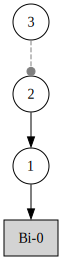

In [9]:
three_levels_hgf.plot_network()

#### Add data

In [10]:
three_levels_hgf = three_levels_hgf.input_data(input_data=u)

Adding 320 new observations.


#### Plot trajectories

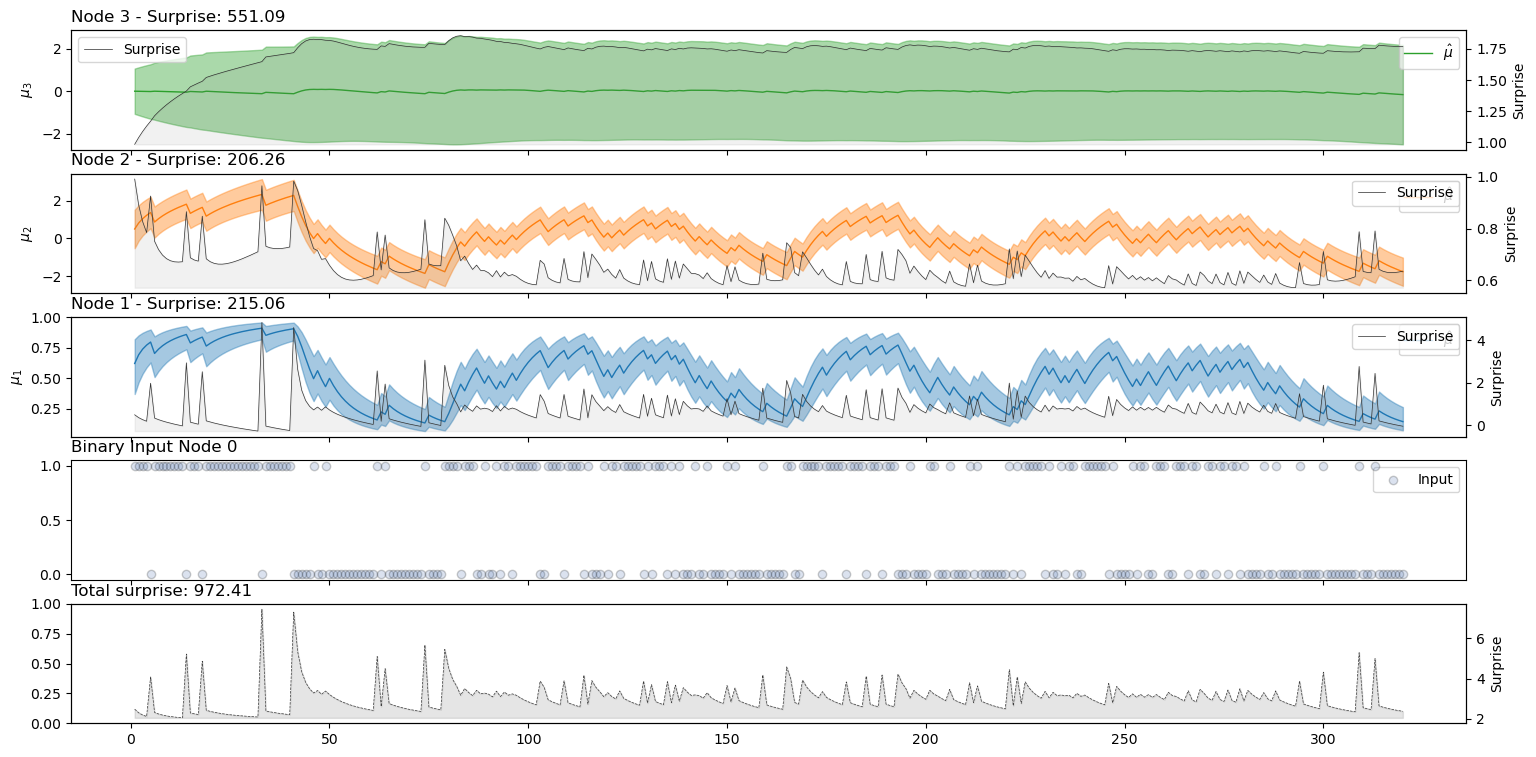

In [11]:
three_levels_hgf.plot_trajectories();

#### Surprise

In [12]:
three_levels_hgf.surprise()

Array(203.21596, dtype=float32)

## Learning parameters with MCMC sampling
In the previous section, we assumed we knew the parameters of the HGF models that were used to filter the input data. This can give us information on how an agent using these values would behave when presented with these inputs. We can also adopt a different perspective and consider that we want to learn these parameters from the data. Here, we are going to set some of the parameters free and use Hamiltonian Monte Carlo methods (NUTS) to sample their probability density.

Because the HGF classes are built on the top of [JAX](https://github.com/google/jax), they are natively differentiable and compatible with optimisation libraries or can be embedded as regular distributions in the context of a Bayesian network. Here, we are using this approach, and we are going to use [PyMC](https://www.pymc.io/welcome.html) to perform this step. PyMC can use any log probability function (here the negative surprise of the model) as a building block for a new distribution by wrapping it in its underlying tensor library [Aesara](https://aesara.readthedocs.io/en/latest/), now forked as [PyTensor](https://pytensor.readthedocs.io/en/latest/). This PyMC-compatible distribution can be found in the {py:obj}`pyhgf.distribution` sub-module.

### Two-level model
#### Creating the model

In [13]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=[u],
    response_function=first_level_binary_surprise,
)

```{note}
The data is being passed to the distribution when the instance is created, so we won't use the `observed` argument in our PyMC model.
```

In [14]:
with pm.Model() as two_levels_binary_hgf:

    # Set a prior over the evolution rate at the second level.
    tonic_volatility_2 = pm.Uniform("tonic_volatility_2", -3.5, 0.0)

    # Call the pre-parametrized HGF distribution here.
    # All parameters are set to their default value, except omega_2.
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_2=tonic_volatility_2))

#### Visualizing the model

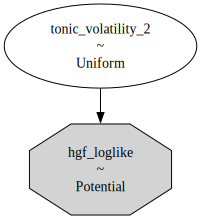

In [15]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [16]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2)

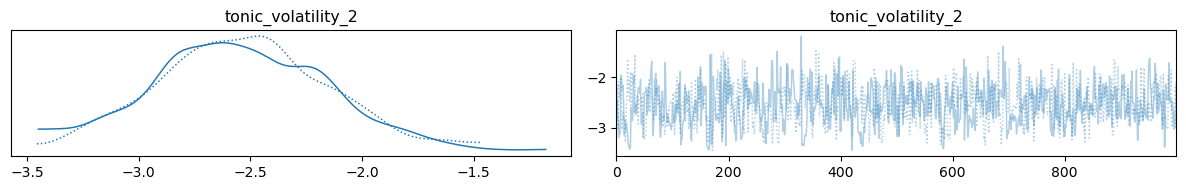

In [17]:
az.plot_trace(two_level_hgf_idata, var_names=["tonic_volatility_2"]);
plt.tight_layout()

### Using the learned parameters
To visualize how the model would behave under the most probable values, we average the $\omega_{2}$ samples and use this value in a new model.

In [18]:
tonic_volatility_2 = az.summary(two_level_hgf_idata)["mean"]["tonic_volatility_2"]

In [19]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": jnp.inf, "2": 0.5},
    initial_precision={"1": 0.0, "2": 1.0},
    tonic_volatility={"1": jnp.inf, "2": tonic_volatility_2},
    tonic_drift={"1": 0.0, "2": 0.0},
    volatility_coupling={"1": 1.0}).input_data(
        input_data=u
    )

Creating a binary Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 320 new observations.


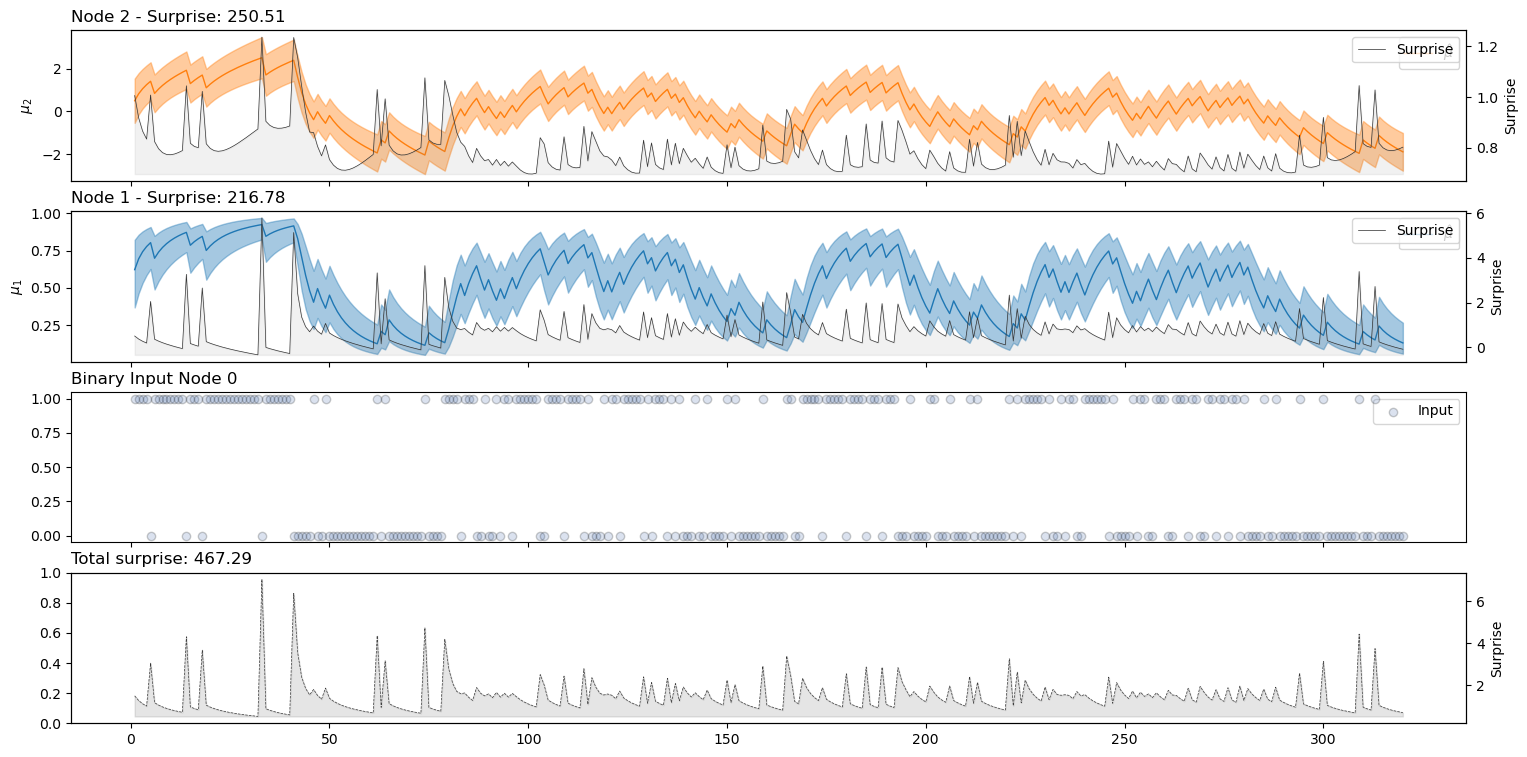

In [20]:
hgf_mcmc.plot_trajectories();

In [21]:
hgf_mcmc.surprise()

Array(202.5339, dtype=float32)

### Three-level model
#### Creating the model

In [22]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=[u],
    response_function=first_level_binary_surprise,
)

In [23]:
with pm.Model() as three_levels_binary_hgf:

     # Set a prior over the evolution rate at the second and third levels.
    tonic_volatility_2 = pm.Uniform("tonic_volatility_2", -4.0, 0.0)
    tonic_volatility_3 = pm.Normal("tonic_volatility_3", -11.0, 2)

    # Call the pre-parametrized HGF distribution here.
    # All parameters are set to their default value except omega_2 and omega_3.
    pm.Potential(
        "hgf_loglike", 
        hgf_logp_op(
            tonic_volatility_2=tonic_volatility_2, 
            tonic_volatility_3=tonic_volatility_3)
    )

#### Visualizing the model

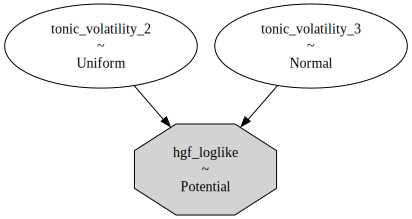

In [24]:
pm.model_to_graphviz(three_levels_binary_hgf)

#### Sampling

In [25]:
with three_levels_binary_hgf:
    three_level_hgf_idata = pm.sample(chains=2)

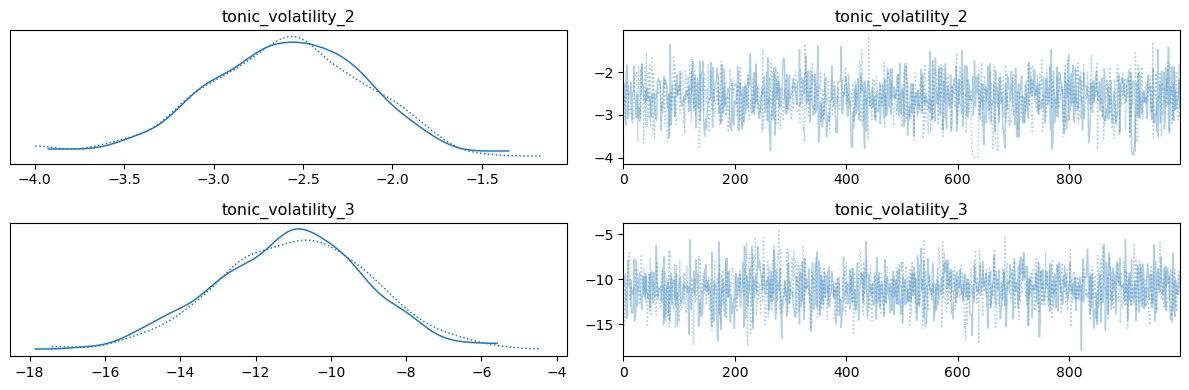

In [26]:
az.plot_trace(three_level_hgf_idata, var_names=["tonic_volatility_2", "tonic_volatility_3"]);
plt.tight_layout()

### Using the learned parameters
To visualize how the model would behave under the most probable values, we average the $\omega_{2}$ samples and use this value in a new model.

In [27]:
tonic_volatility_2 = az.summary(three_level_hgf_idata)["mean"]["tonic_volatility_2"]
tonic_volatility_3 = az.summary(three_level_hgf_idata)["mean"]["tonic_volatility_3"]

In [28]:
hgf_mcmc = HGF(
    n_levels=3,
    model_type="binary",
    initial_mean={"1": jnp.inf, "2": 0.5, "3": 0.0},
    initial_precision={"1": 0.0, "2": 1e4, "3": 1e1},
    tonic_volatility={"1": jnp.inf, "2": tonic_volatility_2, "3": tonic_volatility_3},
    tonic_drift={"1": 0.0, "2": 0.0, "3": 0.0},
    volatility_coupling={"1": 1.0, "2": 1.0}).input_data(
        input_data=u
    )

Creating a binary Hierarchical Gaussian Filter with 3 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 320 new observations.


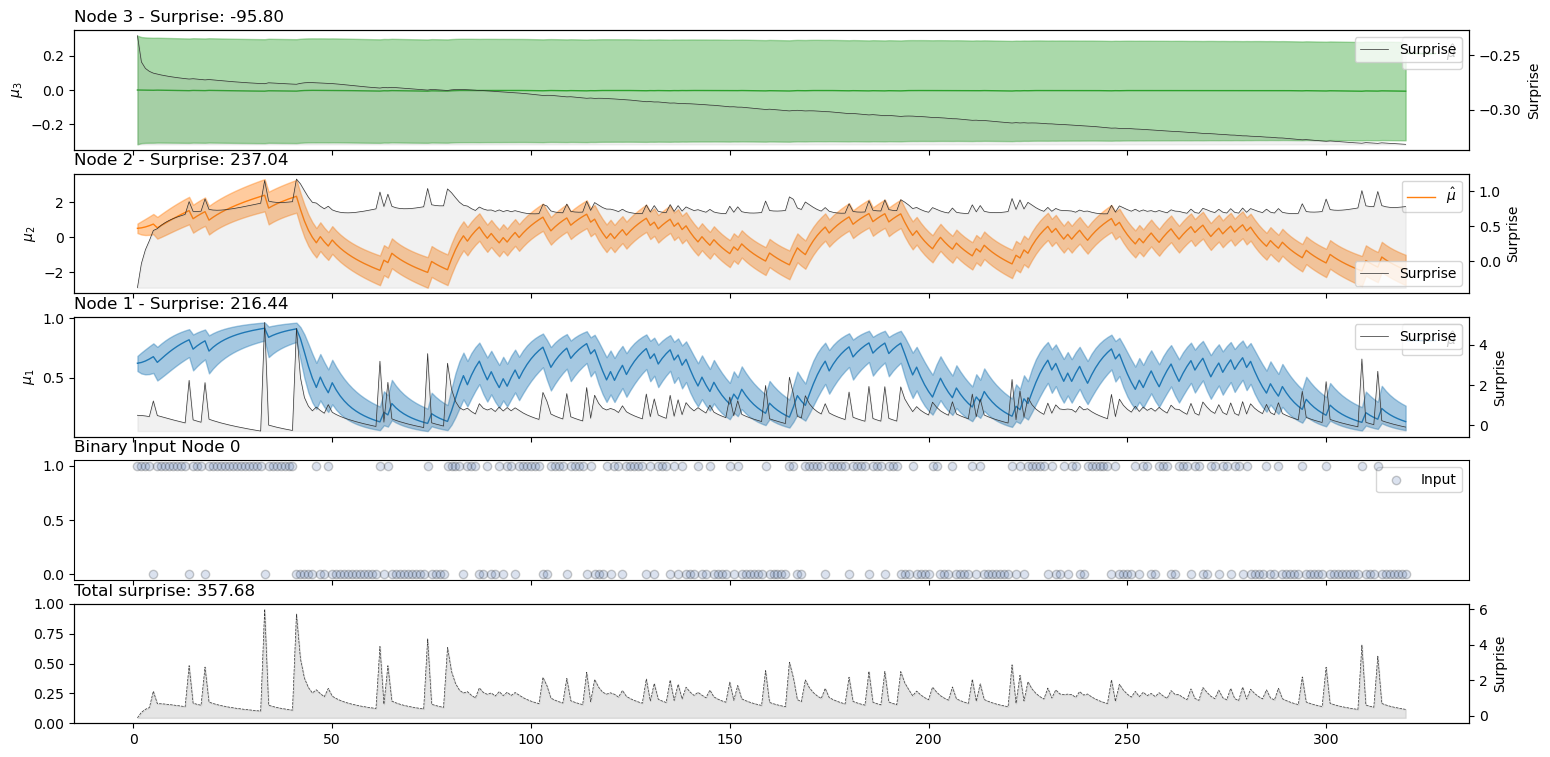

In [29]:
hgf_mcmc.plot_trajectories();

In [30]:
hgf_mcmc.surprise()

Array(203.0253, dtype=float32)

# System configuration

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Thu Nov 16 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.12
jax   : 0.4.16
jaxlib: 0.4.16

arviz     : 0.16.1
jax       : 0.4.16
pymc      : 5.9.1
seaborn   : 0.12.2
matplotlib: 3.7.1
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]

Watermark: 2.4.3

